In [1]:
%matplotlib notebook
import aipy, uvtools
import numpy as np
import pylab as plt

In [2]:
import foregrounds, noise, sigchain, rfi
reload(foregrounds)
reload(noise)
reload(sigchain)
reload(rfi)

<module 'rfi' from 'rfi.pyc'>

In [3]:
fqs = np.linspace(.1,.2,1024,endpoint=False)
lsts = np.linspace(0,2*np.pi,10000, endpoint=False)
times = lsts / (2*np.pi) * aipy.const.sidereal_day
bl_len_ns = 30.

# Foregrounds

## Diffuse Foregrounds

In [4]:
Tsky_mdl = noise.HERA_Tsky_mdl['xx']
vis_fg_diffuse = foregrounds.diffuse_foreground(Tsky_mdl, lsts, fqs, bl_len_ns)

<IPython.core.display.Javascript object>


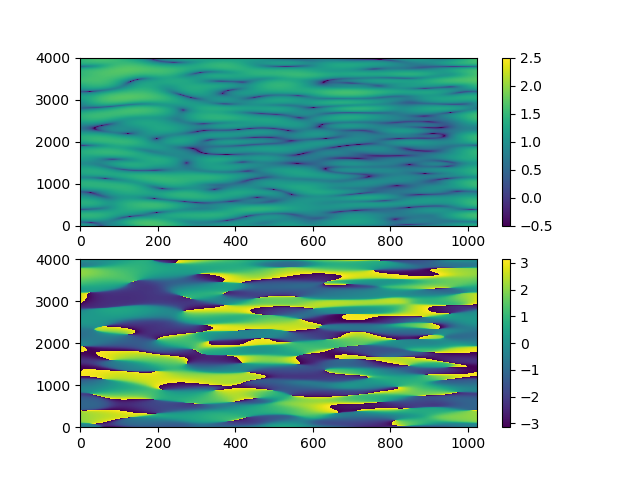

In [5]:
MX, DRNG = 2.5, 3
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(vis_fg_diffuse, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg_diffuse, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

## Point-Source Foregrounds

In [6]:
vis_fg_pntsrc = foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)

<IPython.core.display.Javascript object>


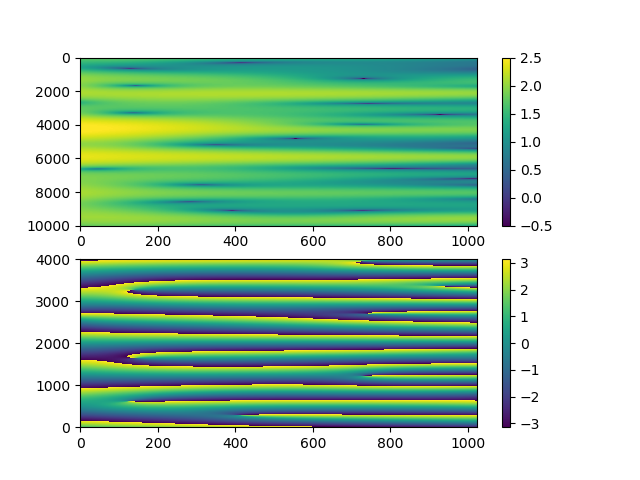

In [7]:
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(vis_fg_pntsrc, mode='log', mx=MX, drng=DRNG); plt.colorbar()#; plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg_pntsrc, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

## Diffuse and Point-Source Foregrounds

In [8]:
vis_fg = vis_fg_diffuse + vis_fg_pntsrc

<IPython.core.display.Javascript object>


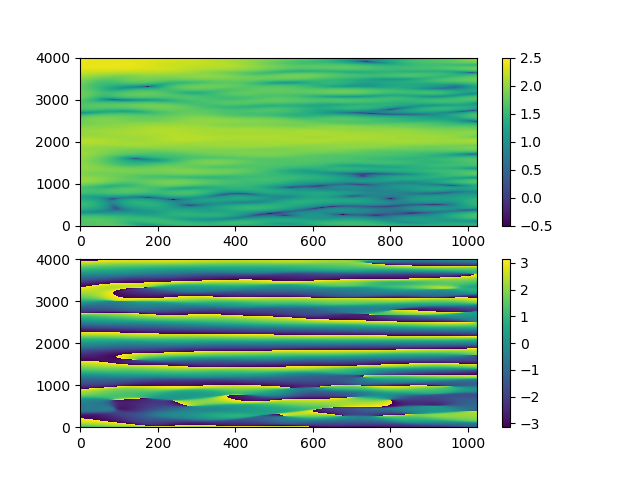

In [9]:
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(vis_fg, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

# Noise

In [10]:
tsky = noise.resample_Tsky(fqs,lsts,Tsky_mdl=noise.HERA_Tsky_mdl['xx'])
t_rx = 150.
nos_jy = noise.sky_noise_jy(tsky + t_rx, fqs, lsts)

<IPython.core.display.Javascript object>


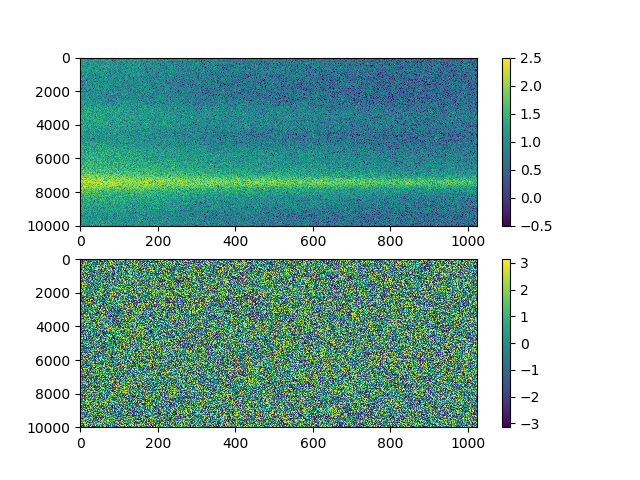

In [11]:
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(nos_jy, mode='log', mx=MX, drng=DRNG); plt.colorbar()#; plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(nos_jy, mode='phs'); plt.colorbar()#; plt.ylim(0,4000)
plt.show()

In [12]:
vis_fg_nos = vis_fg + nos_jy

<IPython.core.display.Javascript object>


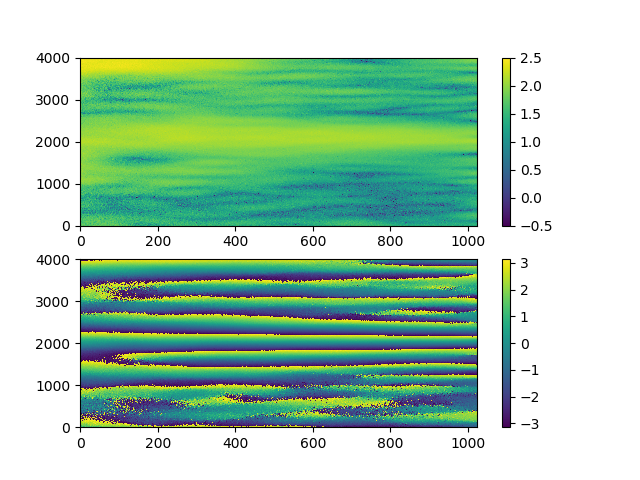

In [13]:
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(vis_fg_nos, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg_nos, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

# RFI

In [14]:
rfi1 = rfi.rfi_stations(fqs, lsts)
rfi2 = rfi.rfi_impulse(fqs, lsts, chance=.02)
rfi3 = rfi.rfi_scatter(fqs, lsts, chance=.001)
rfi_all = rfi1 + rfi2 + rfi3

<IPython.core.display.Javascript object>


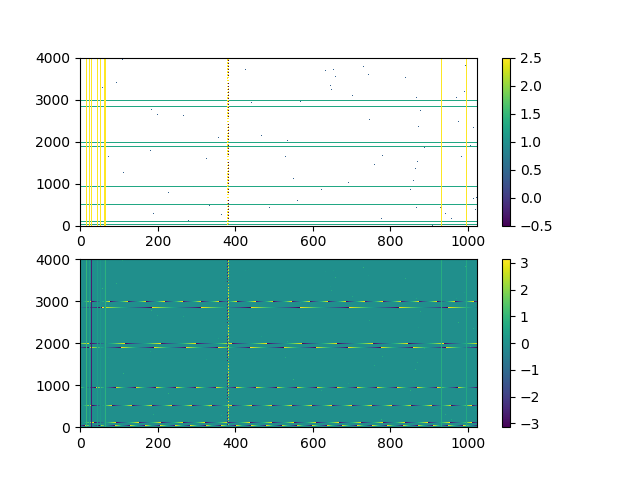

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/uvtools-0.0.0-py2.7.egg/uvtools/plot.py:14: RuntimeWarning: divide by zero encountered in log10


In [15]:
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(rfi_all, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(rfi_all, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

In [16]:
vis_fg_nos_rfi = vis_fg_nos + rfi_all

<IPython.core.display.Javascript object>


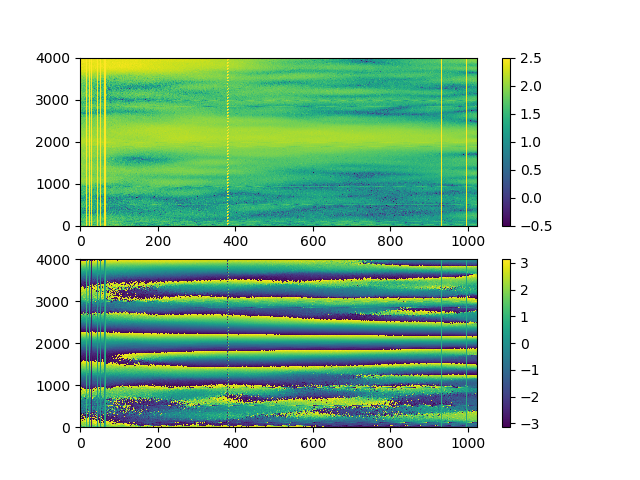

In [17]:
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(vis_fg_nos_rfi, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg_nos_rfi, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

# Gains

<IPython.core.display.Javascript object>


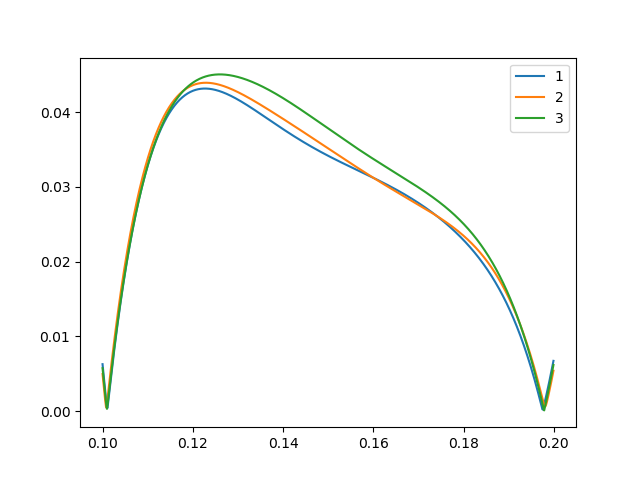

In [18]:
g = sigchain.gen_gains(fqs, [1,2,3])
plt.figure()
for i in g: plt.plot(fqs, np.abs(g[i]), label=str(i))
plt.legend(); plt.show()
gainscale = np.average([np.median(np.abs(g[i])) for i in g])
MXG = MX + np.log10(gainscale)

<IPython.core.display.Javascript object>


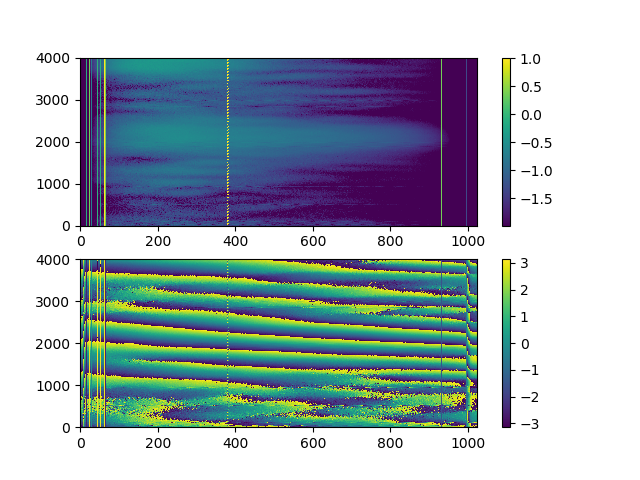

In [19]:
vis_total = sigchain.apply_gains(vis_fg_nos_rfi, g, (1,2))
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(vis_total, mode='log', mx=MXG, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_total, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

# Crosstalk

<IPython.core.display.Javascript object>


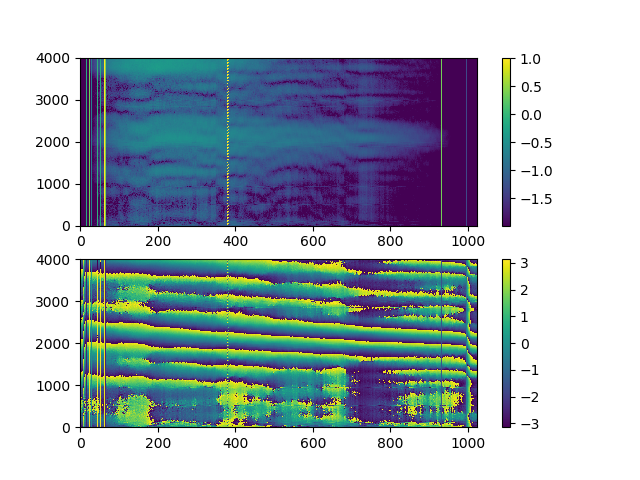

In [20]:
xtalk = sigchain.gen_xtalk(fqs)
vis_xtalk = sigchain.apply_xtalk(vis_fg_nos_rfi, xtalk)
vis_xtalk = sigchain.apply_gains(vis_xtalk, g, (1,2))
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(vis_xtalk, mode='log', mx=MXG, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_xtalk, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

In [25]:
import hera_cal.omni
import aipy
aa = aipy.cal.get_aa('hsa7458_v001', fqs)
info = hera_cal.omni.aa_to_info(aa)
reds = info.get_reds()

In [30]:
ants = list(set([ant for bls in reds for bl in bls for ant in bl]))
pols = ['xx','yy']
antpols = [(ai,p) for ai in ants for p in set(''.join(pols))]
print antpols

[(96, 'y'), (96, 'x'), (65, 'y'), (65, 'x'), (97, 'y'), (97, 'x'), (81, 'y'), (81, 'x'), (64, 'y'), (64, 'x'), (9, 'y'), (9, 'x'), (10, 'y'), (10, 'x'), (43, 'y'), (43, 'x'), (80, 'y'), (80, 'x'), (112, 'y'), (112, 'x'), (104, 'y'), (104, 'x'), (20, 'y'), (20, 'x'), (53, 'y'), (53, 'x'), (22, 'y'), (22, 'x'), (105, 'y'), (105, 'x'), (72, 'y'), (72, 'x'), (89, 'y'), (89, 'x'), (88, 'y'), (88, 'x'), (31, 'y'), (31, 'x')]


In [36]:
gains = sigchain.gen_gains(fqs, antpols)
true_vis, data = {}, {}

In [ ]:
Tsky_mdl = {pol:noise.HERA_Tsky_mdl[pol] for pol in pols}
tsky = {pol:noise.resample_Tsky(fqs,lsts,Tsky_mdl=noise.HERA_Tsky_mdl[pol]) for pol in pols}
rfi_all = rfi.rfi_stations(fqs, lsts)
rfi_all += rfi.rfi_impulse(fqs, lsts, chance=.02)
rfi_all += rfi.rfi_scatter(fqs, lsts, chance=.001)
print len(reds)
for bls in reds:#[:3]:
    print bls
    bl_xyz = aa.get_baseline(*bls[0])
    bl_len_ns = np.sqrt(np.dot(bl_xyz,bl_xyz))
    vis_fg_pntsrc = foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)
    for pol in pols:
        vis_fg_diffuse = foregrounds.diffuse_foreground(Tsky_mdl[pol], lsts, fqs, bl_len_ns)
        true_vis[bls[0]+(pol,)] = vis_fg_pntsrc + vis_fg_diffuse
        for (i,j) in bls:
            ai,aj = (i,pol[0]), (j,pol[1])
            print (ai,aj)
            nos_jy = noise.sky_noise_jy(tsky[pol] + 150., fqs, lsts)
            xtalk = sigchain.gen_xtalk(fqs)
            vis_xtalk = sigchain.apply_xtalk(true_vis[bls[0]+(pol,)] + nos_jy + rfi_all, xtalk)
            data[(i,j,pol)] = sigchain.apply_gains(vis_xtalk, gains, (ai,aj))

27
[(9, 31), (20, 65), (22, 89), (53, 96), (64, 104), (72, 81), (112, 10), (105, 20), (81, 43), (88, 53)]
((9, 'x'), (31, 'x'))
((20, 'x'), (65, 'x'))
((22, 'x'), (89, 'x'))
((53, 'x'), (96, 'x'))
((64, 'x'), (104, 'x'))
((72, 'x'), (81, 'x'))
((112, 'x'), (10, 'x'))
((105, 'x'), (20, 'x'))
((81, 'x'), (43, 'x'))
((88, 'x'), (53, 'x'))
((9, 'y'), (31, 'y'))
((20, 'y'), (65, 'y'))
((22, 'y'), (89, 'y'))
((53, 'y'), (96, 'y'))
((64, 'y'), (104, 'y'))
((72, 'y'), (81, 'y'))
((112, 'y'), (10, 'y'))
((105, 'y'), (20, 'y'))
((81, 'y'), (43, 'y'))
((88, 'y'), (53, 'y'))
[(65, 72), (96, 105)]
((65, 'x'), (72, 'x'))
((96, 'x'), (105, 'x'))
((65, 'y'), (72, 'y'))
((96, 'y'), (105, 'y'))
[(31, 105), (43, 112), (96, 9), (65, 22), (89, 72), (104, 88)]
((31, 'x'), (105, 'x'))
((43, 'x'), (112, 'x'))
((96, 'x'), (9, 'x'))
((65, 'x'), (22, 'x'))
((89, 'x'), (72, 'x'))
((104, 'x'), (88, 'x'))
((31, 'y'), (105, 'y'))
((43, 'y'), (112, 'y'))
((96, 'y'), (9, 'y'))
((65, 'y'), (22, 'y'))
((89, 'y'), (72, '

((105, 'x'), (112, 'x'))
((20, 'x'), (10, 'x'))
((64, 'x'), (20, 'x'))
((88, 'x'), (22, 'x'))
((80, 'x'), (31, 'x'))
((104, 'x'), (65, 'x'))
((9, 'y'), (81, 'y'))
((22, 'y'), (97, 'y'))
((31, 'y'), (43, 'y'))
((53, 'y'), (89, 'y'))
((105, 'y'), (112, 'y'))
((20, 'y'), (10, 'y'))
((64, 'y'), (20, 'y'))
((88, 'y'), (22, 'y'))
((80, 'y'), (31, 'y'))


<IPython.core.display.Javascript object>


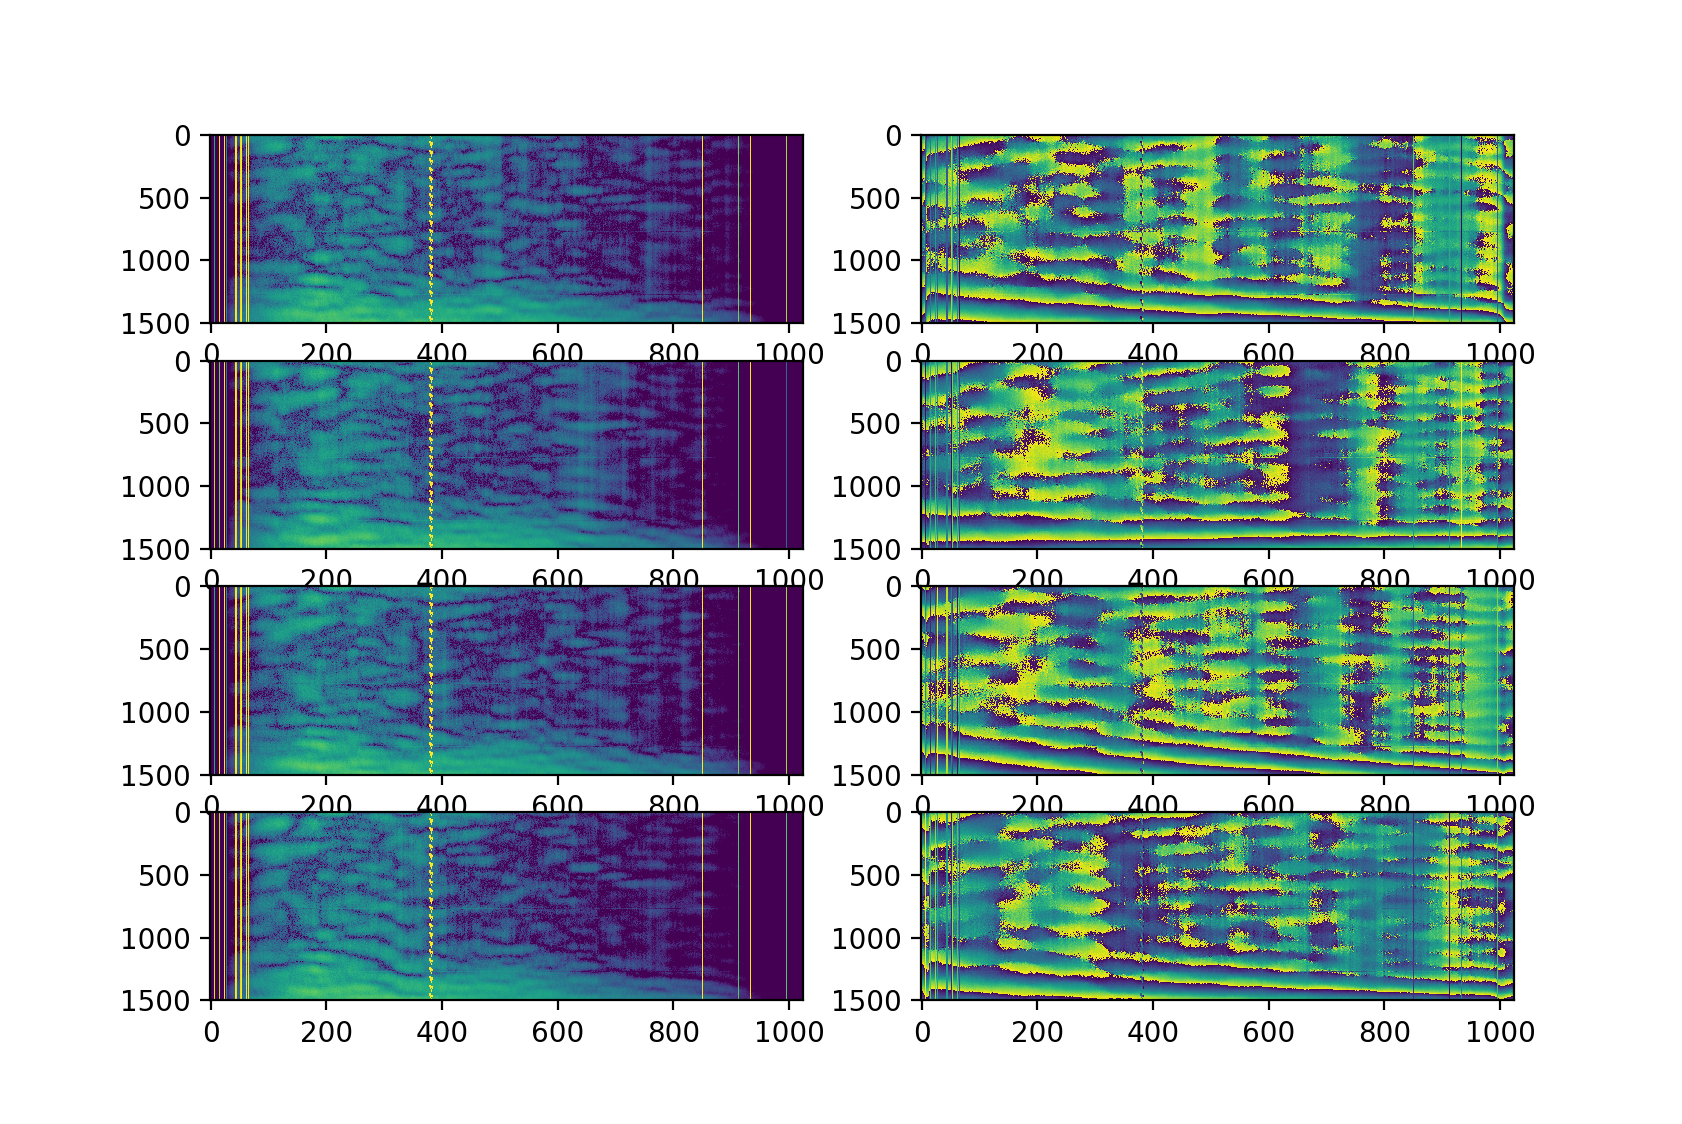

In [51]:
plt.figure()
for cnt,bl in enumerate(reds[0][:4]):
    d = data[bl+('xx',)][:1500]
    plt.subplot(4,2,2*cnt+1)
    uvtools.plot.waterfall(d, mode='log', mx=0, drng=2)
    plt.subplot(4,2,2*cnt+2)
    uvtools.plot.waterfall(d, mode='phs')
plt.show()

<IPython.core.display.Javascript object>


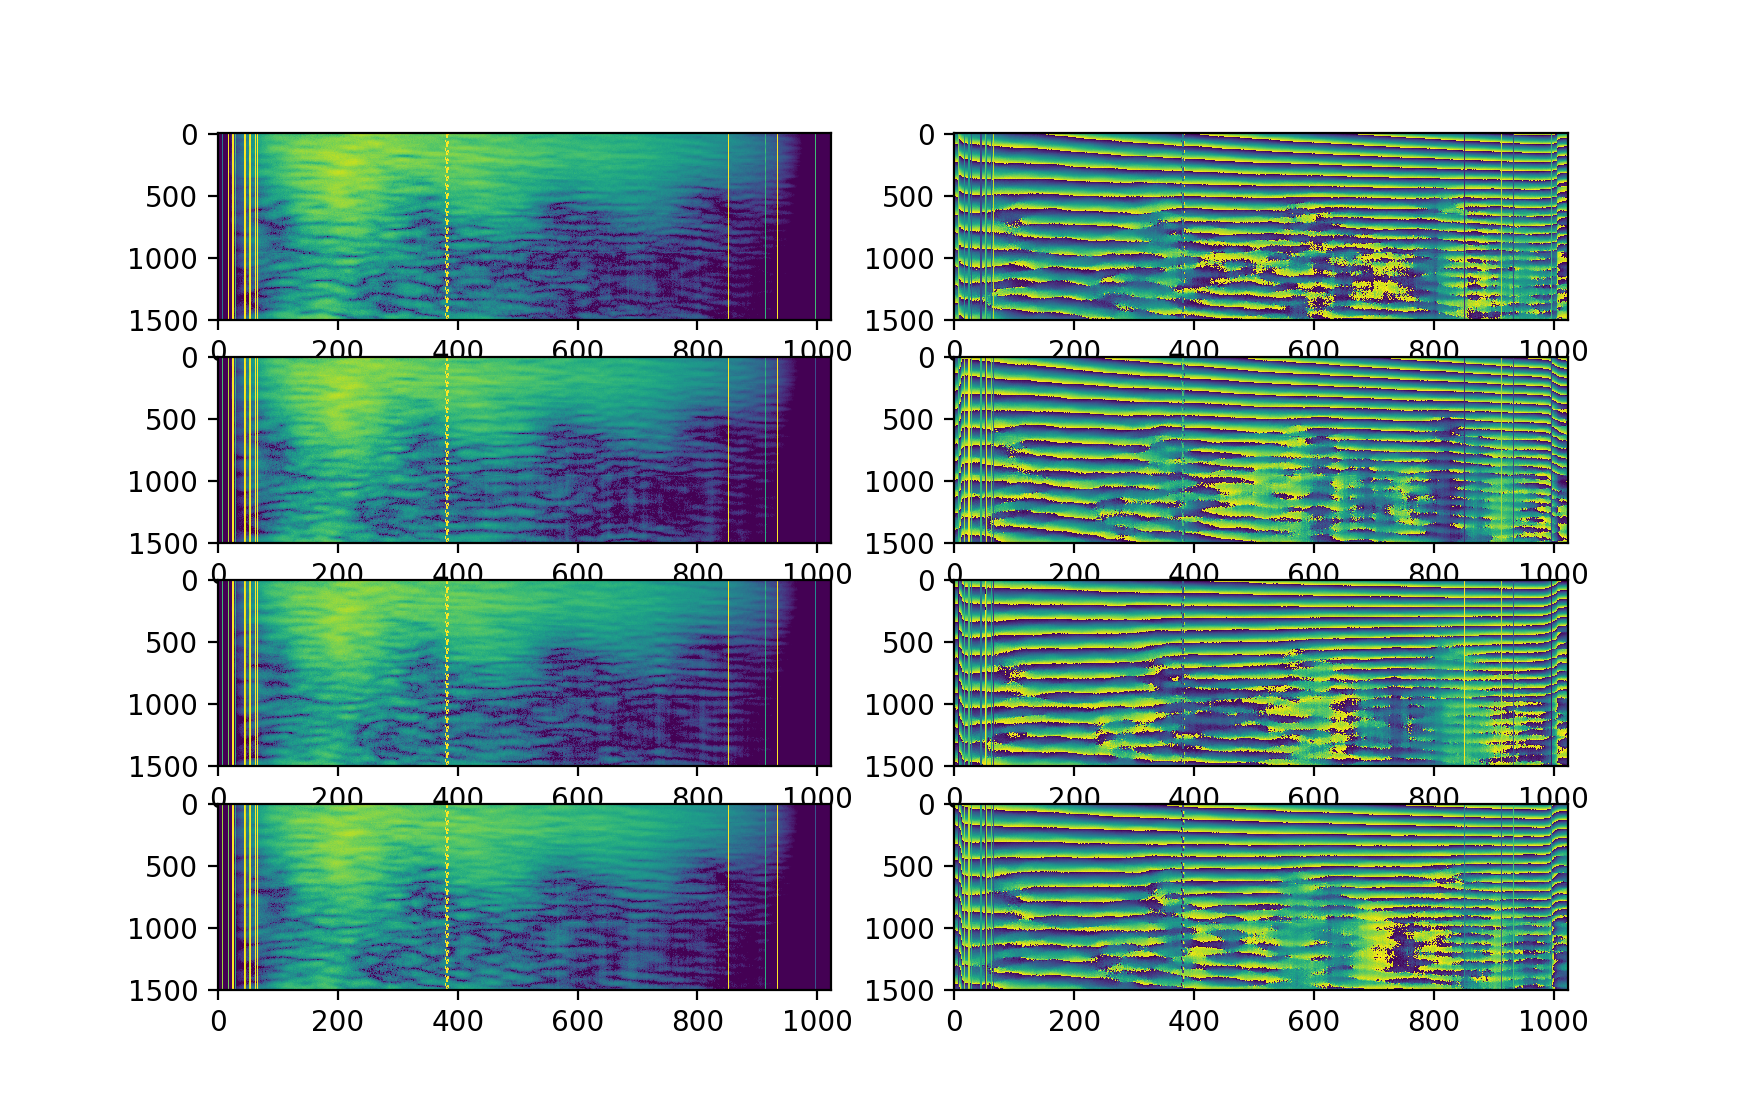

In [50]:
plt.figure()
for cnt,bl in enumerate(reds[2][:4]):
    d = data[bl+('xx',)][:1500]
    plt.subplot(4,2,2*cnt+1)
    uvtools.plot.waterfall(d, mode='log', mx=0, drng=2)
    plt.subplot(4,2,2*cnt+2)
    uvtools.plot.waterfall(d, mode='phs')
plt.show()